This example will show how to use and extend the `Detectron2Base` interface.

This interface extends the base `DetectImageObjects` interface from [smqtk-detection] (defined [here][smqtk-detection-i-dio]), which describes the object detection and classification transformation given raw image matrices as input ("raw" = "just loaded from disk").
The `Detectron2Base` interface extends the above to be specific to perform this inference operation with Detectron2 compatible models and configurations, as defined for and produces by ths LEARN framework.

The "use" we will show in this example will be:
* Predict objects and classifications on an image with a plugin instance.
* How to extend `Detectron2Base` for new model architectures.

---

This example assumes that you...
* have an appropriate environment to import and use the LEARN package.
* have a basic familiarity with [smqtk-core].
* have a machine with at least one available GPU (otherwise a change to a cell may be required)

This example will NOT...
* introduce [smqtk-core] or it's concepts.


[smqtk-core]: https://smqtk-core.readthedocs.io/en/stable/index.html
[smqtk-core-docs]: https://smqtk-core.readthedocs.io/en/stable/plugins_configuration.html#
[smqtk-core-examples]: https://smqtk-core.readthedocs.io/en/stable/plugins_configuration.html#examples
[smqtk-detection]: https://github.com/Kitware/SMQTK-Detection
[smqtk-detection-i-dio]: https://github.com/Kitware/SMQTK-Detection/blob/master/smqtk_detection/interfaces/detect_image_objects.py

---
# Get Supporting Data
Let's grab some data to support this example, including an image file as well as the model files to support inferencing.

We will use a COCO2014 trained FasterRCNN model for this example.
The detectron2 configuration file for this network can be found at `configs/detectron_config/coco2014_faster_rcnn_R_50_FPN_3x.yaml` in the LEARN repository.
The model weights can be retrieved by downloading the archive at [this link] and untar it.
We will make use of the `coco2014_faster_rcnn_R_50_FPN_3x.pkl` weights model file inside.

We will also grab an example image from the COCO dataset.
We will use this image in three ways to show the possible forms of input matrices that should be acceptable to this class interface and plugin:
* original 3-channel RGB.
* single channel with the channel dimension having a size of 1.
* single channel with no channel dimension.


[this link]: https://drive.google.com/file/d/1f-eDrGCLhBRPoqZFgWz-CNazleyWpQVW/view?usp=sharing

In [1]:
from pathlib import Path
import os

# Assuming interpreter for this notebook is based in the same directory.
# If not, the check later in this cell will likely fail.
model_config_filepath = Path.cwd() / "../configs/detectron_config/coco2014_faster_rcnn_R_50_FPN_3x.yaml"
if not model_config_filepath.exists():
    raise ValueError(
        f"Double check the `model_config_filepath` referrs to a real file. "
        f"Currently resolving to: {model_config_filepath}")

# Set the path appropriately to point to the weights file.
model_weights_filepath = Path("~/data/darpa-lwll/small_pretrained_networks/coco2014_faster_rcnn_R_50_FPN_3x.pkl").expanduser()
if not model_weights_filepath.exists():
    raise ValueError(
        f"Double check the `model_weights_filepath` refers to a real file. "
        f"Currently resolving to: {model_weights_filepath}")

img_mat_3chan.shape  = (480, 640, 3)
img_mat_1chan.shape  = (480, 640, 1)
img_mat_nochan.shape = (480, 640)


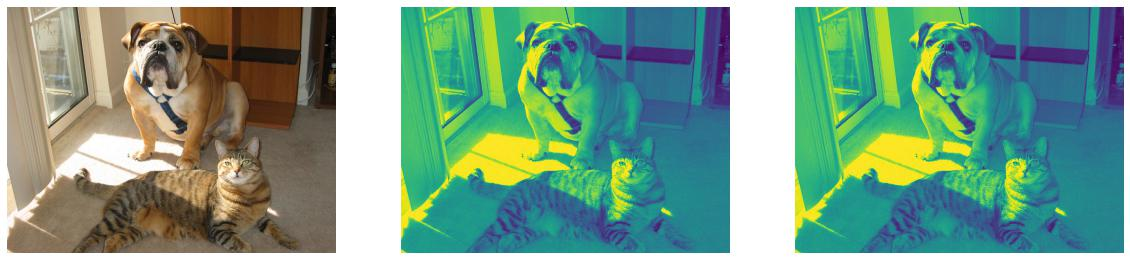

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import urllib

# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"


test_image_filename = 'data/catdog.jpg'
_ = urllib.request.urlretrieve('https://farm1.staticflickr.com/74/202734059_fcce636dcd_z.jpg', test_image_filename)

img_mat_3chan = np.asarray(PIL.Image.open(test_image_filename))
img_mat_1chan = img_mat_3chan[:, :, 0:1]
img_mat_nochan = img_mat_3chan[:, :, 0]

print(f"img_mat_3chan.shape  = {img_mat_3chan.shape}")
print(f"img_mat_1chan.shape  = {img_mat_1chan.shape}")
print(f"img_mat_nochan.shape = {img_mat_nochan.shape}")

fig, ax_list = plt.subplots(1, 3, figsize=(20, 5))
[ax.axis('off') for ax in ax_list]
ax_list[0].imshow(img_mat_3chan)
ax_list[1].imshow(img_mat_1chan)
ax_list[2].imshow(img_mat_nochan)

---
# Instantiate Plugin instance.

Here will instantiate our algorithm instance. An obvious way is to directly import the class and call it's constructor, which we show below.

Since the `Detectron2Base` interface inherits from [smqtk-core], it is also possible to construct a plugin instance given a JSON-like configuration dictionary.
This will be shown in a raw-format cell that may be "un-commented" to explore such usage.


[smqtk-core]: https://smqtk-core.readthedocs.io/en/stable/index.html

In [3]:
from learn.smqtk_plugins.detect_image_objects.detection2_generalizedrcnn import Detectron2GeneralizedRCNN


detector = Detectron2GeneralizedRCNN(
    detectron_config = model_config_filepath.as_posix(),
    weights_uri = model_weights_filepath.as_posix(),
    batch_size = 2,
    num_workers = 1,
    # If you do not have a GPU, change this to "cpu"
    # If you need to run on a different GPU cart, change
    # the ":0" component to the appropriate GPU ID to use.
    load_device = "cuda:0",
)

# Predict
Next we will perform inference on the input imagery defined above.
In this example, we have our image matrices already fully defined and stored in memory, so we can simply pass them in as a list.
We will also simply cast the output iterators into lists since we happen to know that the output quantity is constrained and able to fit into local resources easily.
See the [`DetectImageObjects` interface](https://github.com/Kitware/SMQTK-Detection/blob/master/smqtk_detection/interfaces/detect_image_objects.py#L19) for API information.

**Note that this is not the required use-case / interaction.**
The interface API defines that plugins should be able to support iterables of images.
This includes bounded containers like lists, tuples and numpy ndarrays, but also includes unbounded iterators for such cases like streaming/continuous imagery.

After prediction we will simply visualize the detections on their respective images. By arbitrary choice, we are only going to show detections above 0.75 confidence.

In [4]:
# Inference on each input `img_mat_*` image defined above.
image_iterable = [img_mat_3chan, 
                  img_mat_1chan,
                  img_mat_nochan]

img_pred_detections = [list(img_dets) for img_dets in detector.detect_objects(image_iterable)]

print(f"len(img_pred_detections) = {len(img_pred_detections)}")
for i, dets in enumerate(img_pred_detections):
    print(f"Image {i} detections = {len(dets)}")

/home/local/KHQ/paul.tunison/.python_virtualenvs/learn/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/local/KHQ/paul.tunison/.python_virtualenvs/learn/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


len(img_pred_detections) = 3
Image 0 detections = 10
Image 1 detections = 12
Image 2 detections = 12


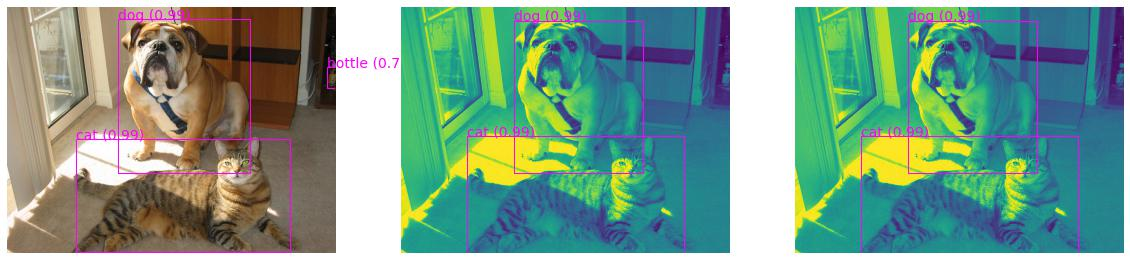

In [5]:
# Visualize detections for each input.
# Aibitrarilly, only showing 
import matplotlib.patches as patches

conf_threshold = 0.75

fig, ax_list = plt.subplots(1, 3, figsize=(20, 5))
[ax.axis('off') for ax in ax_list]

for ax, img_mat, img_dets in zip(ax_list, image_iterable, img_pred_detections):
    ax.imshow(img_mat)
    for aabb, pred_dict in img_dets:
        # Pick the highest confidence label for display
        conf, lbl = sorted((v, k) for k, v in pred_dict.items())[0]
        if conf < conf_threshold:
            continue
        
        xy = aabb.min_vertex.round().astype(int)
        wh = aabb.deltas.round().astype(int)
        rect = patches.Rectangle(xy, wh[0], wh[1],
                                 linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)
        ax.text(*xy, f"{lbl} ({conf:0.2f})", color="magenta", fontsize=14)

---

# Creating a new Plugin

In the above cells, we've highlighted using the plugin `Detectron2GeneralizedRCNN`.
As the name might suggest, this plugin is intended to invoke models/configurations that descend from the `detectron2.modeling.GeneralizedRCNN` type.

Plugins implementing `Detectron2Base` are required to override the `_get_augmentation` abstract method.
This defines how raw images are to be preprocessed by the `DataLoader` before being passed as input to the model.

Additionally, while not abstract methods, the `_forward` and `_iterate_output` may be overridden to specialize how a class of models are invoked to perform inference, as well as override how to post-process output detections to match the `DetectImageObjects` output API.


In [6]:
import detectron2.data.transforms as T
from smqtk_detection.utils.bbox import AxisAlignedBoundingBox
import torch
from typing import Any, Dict, Hashable, Iterable, List, Tuple

from learn.smqtk_plugins.detect_image_objects.detectron2_base import Detectron2Base


class Detectron2MyArchitecture (Detectron2Base):
    
    def _get_augmentation(self) -> T.Augmentation:
        """
        Create an return required inference-time data augmentation required by
        MyArchitecture.
        Create a new T.Augmentation instance here and return it.
        """
        
    def _forward(self, model: torch.nn.Module, batch_inputs: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """ call the `model` with the given `batch_inputs` appropriately for this model. """

    def _iterate_output(self, single_output: Dict[str, Any]) -> Iterable[Tuple[AxisAlignedBoundingBox, Dict[Hashable, float]]]:
        """ Transform appropriately the model's output to the interface-promised format. """